In [3]:
import camb
from camb import model, initialpower
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pk_plot_library as pplib
pplib.imports()
import astro_utils.plots as auplt


In [29]:
# initialize parameters, settings for plot.

# Planck15 params: ombh2 = 0.02230, omch2 = 0.1188, H0 = 67.74, ns = 0.9667
# idk if camb gives the power spectrum in co-moving units or not
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.74, ombh2=0.0223, omch2=0.1188)
pars.InitPower.set_params(ns=0.9667)
#Note non-linear corrections couples to smaller scales than you want
mink = 1e-2; maxk = 5; npts = 200; z = 1

pars.set_matter_power(redshifts=[z], kmax=maxk)

pks = []

def plot_pk(pks, cmap = 'rocket', frac_type = 'prev'):
    plt.clf()
    fig, axs = plt.subplots(2, 1, sharex = True, 
            gridspec_kw = dict(height_ratios = [1, 1], hspace = 0.1), figsize = (4, 8))
    plt.sca(axs[0])
    ncols = 7
    colors = sbn.color_palette(cmap, n_colors = ncols)
    color_i = 0
    for i in range(len(pks)):
        if 'color' not in pks[i][2]:            
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], color = colors[color_i], **pks[i][2])
            color_i += 1
        else:
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], **pks[i][2])
    plt.ylabel("k P(k) (Mpc / h)$^2$", fontsize = 14)
    plt.legend(frameon = False, loc = 'center left', fontsize = 13, bbox_to_anchor = (1, 0.5))
    plt.title('z = %.1f'%z)
    plt.loglog()
    axs[0].tick_params(which = 'both', direction = 'in', labelsize = 12)
    
    plt.sca(axs[1])
    if frac_type == 'prev':
        plt.ylabel(r'$P_{i + 1} (k) / P_{i}(k)$', fontsize = 14)
    elif frac_type == 'lin':
        plt.ylabel(r'$P_i (k) / P_m^L (k)$', fontsize = 14)
    plt.xlabel(pplib.wnum(False), fontsize = 14)
    axs[1].tick_params(which = 'both', direction = 'in', labelsize = 12)
    
    colors = sbn.color_palette(cmap, n_colors = ncols)
    color_i = 0
    for i in range(1, len(pks)):
        if frac_type == 'prev':
            vals = pks[i][1] / pks[i-1][1]
        elif frac_type == 'lin':
            vals = pks[i][1] / pks[0][1]
        if 'color' not in pks[i][2]:            
            plt.plot(pks[i][0], vals, color = colors[color_i], **pks[i][2])
            color_i += 1
        else:
            plt.plot(pks[i][0], vals, **pks[i][2])
    
    axs[1].hlines(1, *axs[1].get_xlim(), linestyle = 'dashed', color = 'gray')
    axs[1].set_yscale('log')
    axs[1].set_ylim(1e-2, 100)
    return fig, axs



(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

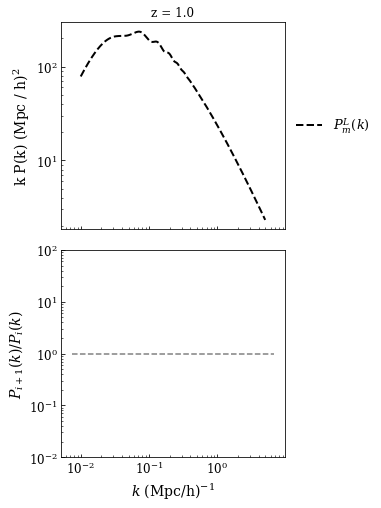

In [30]:


#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, _, pk = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)

# format into dict
pkkw = dict(
    label = '$P_m^L (k)$',
    color = 'black',
    linestyle = 'dashed',
    linewidth = 2
)

pks.append([kh, pk[0,:], pkkw])


plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

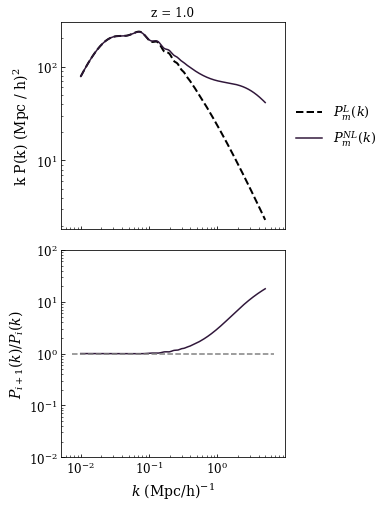

In [31]:
#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, _, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)
pkkw = dict(
    label = '$P_m^{NL} (k)$'
)
pks.append([kh_nonlin, pk_nonlin[0, :], pkkw])
plot_pk(pks)

galaxy bias: 2.085672443425789
HI bias: 1.2512342415607032


(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

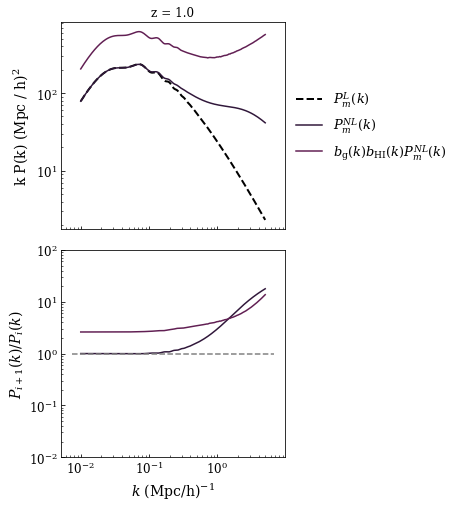

In [32]:
# including galaxy and HI bias
#loading gal bias
import pickle as pkl
from scipy.interpolate import interp1d
galb = pkl.load(open('gal_bias_demo_50.pkl', 'rb'))
hib = pkl.load(open('hi_bias_demo_50.pkl', 'rb'))

const_gbias = galb[1][0]
const_hbias = hib[1][0]
print('galaxy bias:',const_gbias)
print('HI bias:', const_hbias)

#tested with other kinds (quadratic), didn't have any difference
interp_f = interp1d(galb[0], galb[1], kind = 'linear', fill_value = const_gbias, bounds_error = False)
galb_intp = interp_f(kh)

interp_f = interp1d(hib[0], hib[1], kind = 'linear', fill_value = const_hbias, bounds_error = False)
hib_intp = interp_f(kh)
pkkw = dict(
    label = r'$b_{\rm{g}} (k) b_{\rm{HI}} (k) P_m^{NL} (k)$'
)
pks.append([kh, galb_intp * hib_intp * pk_nonlin[0, :], pkkw])
plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

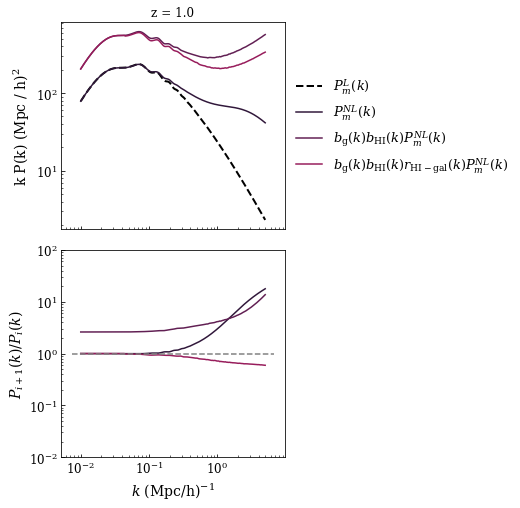

In [33]:
# including the correlation coefficient
cc = pkl.load(open('higal_cc_demo_50.pkl', 'rb'))
interp_f = interp1d(cc[0], cc[1], kind = 'linear', fill_value = 1, bounds_error = False)
cc_intp = interp_f(kh)
pkkw = dict(
    label = r'$b_{\rm{g}} (k) b_{\rm{HI}} (k) r_{\mathrm{HI-gal}} (k) P_m^{NL} (k)$'
)
pks.append([kh, cc_intp * galb_intp * hib_intp * pk_nonlin[0, :], pkkw])
plot_pk(pks)

# Poster Plot

<Figure size 432x288 with 0 Axes>

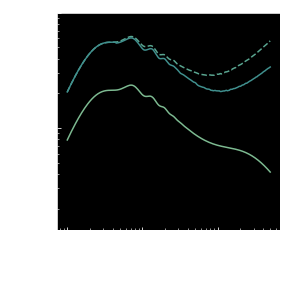

In [46]:
def plot_pk_poster(pks, cmap = 'crest'):
    plt.clf()
    fig = plt.figure(figsize = (4, 4))
    ax = plt.gca()
    
    ncols = 6
    colors = sbn.color_palette(cmap, n_colors = ncols)
    color_i = 0
    for i in range(len(pks)):
        if 'color' not in pks[i][2]:            
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], color = colors[color_i], **pks[i][2])
            color_i += 1
        else:
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], **pks[i][2])
    plt.ylabel("k P(k) (Mpc / h)$^2$", fontsize = 14)
#     plt.legend(frameon = False, loc = 'center left', fontsize = 13, bbox_to_anchor = (1, 0.5))
#     plt.title('z = %.1f'%z)
    plt.loglog()
    ax.tick_params(which = 'both', direction = 'in', labelsize = 12)
    
    
    return fig, ax
pks[1][2]['label'] = '$P_m$'
pks[2][2]['label'] = '$b_{\mathrm{g}} b_{\mathrm{HI}} P_m$'
pks[3][2]['label'] = '$b_{\mathrm{g}} b_{\mathrm{HI}} r_{\mathrm{HI-g}} P_m$'

pks[2][2]['linestyle'] = 'dashed'
fig, ax = plot_pk_poster(pks[1:])
# ax.legend(loc = 'lower left', frameon = False, fontsize = 12)
ax.set_xlabel(pplib.wnum(), fontsize = 14)
ax.set_ylim(13, 1e3)
auplt.dark(fig, ax)
fig.set(facecolor = 'none')
plt.savefig('demo_poster_noleg_square.png', dpi = 800, bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

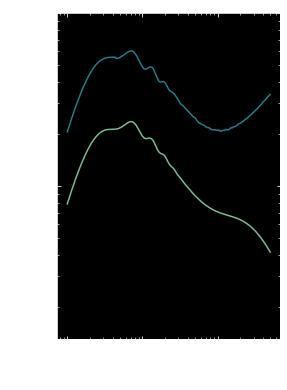

In [76]:
def plot_pk_poster(pks, cmap = 'crest'):
    plt.clf()
    fig = plt.figure(figsize = (4, 6))
    ax = plt.gca()
    
    ncols = 6
    colors = sbn.color_palette(cmap, n_colors = ncols)
    color_i = 0
    for i in range(len(pks)):
        if 'color' not in pks[i][2]:            
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], color = colors[color_i], **pks[i][2])
            color_i += 3
        else:
            plt.plot(pks[i][0], pks[i][0] * pks[i][1], **pks[i][2])
    plt.ylabel("k P(k) (Mpc / h)$^2$", fontsize = 14)
#     plt.legend(frameon = False, loc = 'center left', fontsize = 13, bbox_to_anchor = (1, 0.5))
#     plt.title('z = %.1f'%z)
    plt.loglog()
    ax.tick_params(which = 'both', direction = 'in', labelsize = 12, top = True, right = True)
    
    
    return fig, ax
pks[1][2]['label'] = '$P_m$'
pks[2][2]['label'] = '$b_{\mathrm{g}} b_{\mathrm{HI}} P_m$'
pks[3][2]['label'] = '$b_{\mathrm{g}} b_{\mathrm{HI}} r_{\mathrm{HI-g}} P_m$'

pks[2][2]['linestyle'] = 'dashed'
fig, ax = plot_pk_poster([pks[1], pks[3]])
# ax.legend(loc = 'lower left', frameon = False, fontsize = 12)
ax.set_xlabel(pplib.wnum(False), fontsize = 14)
ax.set_ylim(13, 1e3)
auplt.dark(fig, ax)
fig.set(facecolor = 'none')
plt.savefig('demo_poster_noleg_only2.png', dpi = 800, bbox_inches = 'tight')

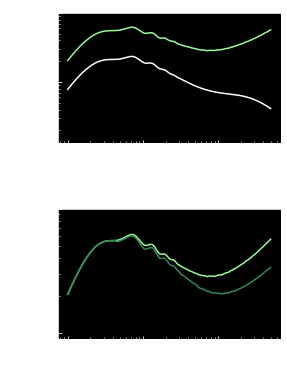

In [71]:
# trying in two different panels
fig, axes = plt.subplots(2, 1, sharex = True,
            gridspec_kw = dict(height_ratios = [1, 1], hspace = 0.5), figsize = (4, 6))
axes[0].loglog(pks[1][0], pks[1][1] * pks[1][0], **pks[1][2], color = 'white')
pks[2][2]['linestyle'] = 'solid'
axes[0].set_ylim(13, 1e3)
plt.figtext(-0.05, 0.5,"k P(k) (Mpc / h)$^2$", rotation = 'vertical',fontsize = 14, va = 'center', ha = 'left', color = 'white')
axes[0].loglog(pks[2][0], pks[2][0]*pks[2][1], **pks[2][2], color = 'palegreen')
axes[1].loglog(pks[2][0], pks[2][0]*pks[2][1], **pks[2][2], color = 'palegreen')
axes[1].loglog(pks[3][0], pks[3][0]*pks[3][1], **pks[3][2], color = 'seagreen')
axes[1].set_xlabel(pplib.wnum(), fontsize = 14)
axes[0].tick_params(which = 'both', direction = 'in', labelsize = 12)
axes[1].tick_params(which = 'both', direction = 'in', labelsize = 12)
axes[1].set_ylim(9e1, 1e3)
auplt.dark(fig, axes)
fig.set(facecolor = 'none')
fig.savefig("bias_cc_separate_demo_bigspace.png", dpi = 800, bbox_inches = 'tight')

# Redshift-Space Cross-Power Example

<Figure size 432x288 with 0 Axes>

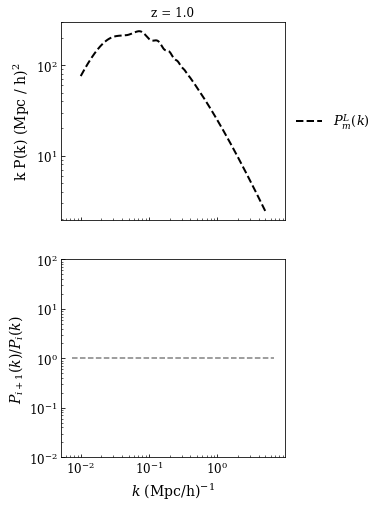

In [7]:
pks = []

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, _, pk = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)

# format into dict
pkkw = dict(
    label = '$P_m^L (k)$',
    color = 'black',
    linestyle = 'dashed',
    linewidth = 2
)

pks.append([kh, pk[0,:], pkkw])


plot_pk(pks)

<Figure size 432x288 with 0 Axes>

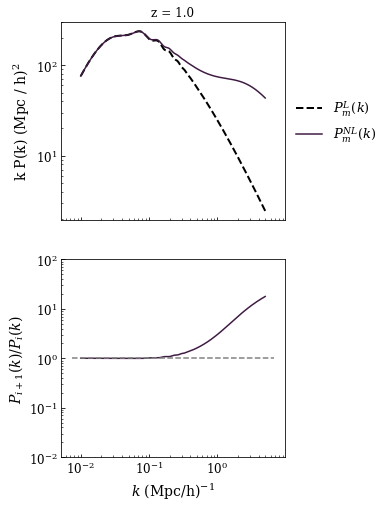

In [8]:
#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, _, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)
pkkw = dict(
    label = '$P_m^{NL} (k)$'
)
pks.append([kh_nonlin, pk_nonlin[0, :], pkkw])
plot_pk(pks)

<Figure size 432x288 with 0 Axes>

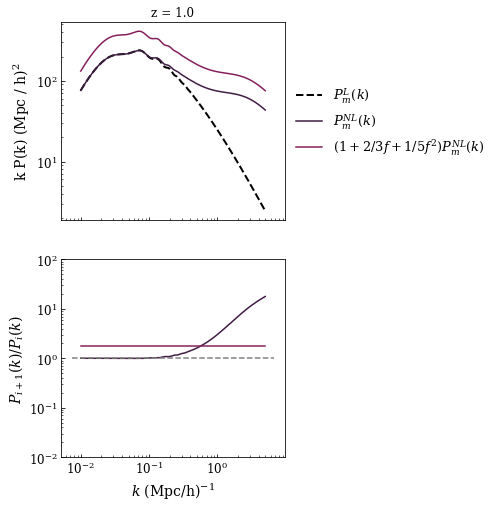

In [9]:
# linear Kaiser RSD
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def kaiser(z, bias):
    f = growth_factor(z)
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)
def growth_factor(z):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    return f
lnksr = kaiser(z, 1)
pkkw = dict(
    label = r'$(1 + 2/3 f + 1/5 f^2) P_m^{NL} (k)$'
)
pks.append([kh_nonlin, pk_nonlin[0, :] * lnksr, pkkw])

plot_pk(pks)

In [10]:
# non-linear Kaiser RSD, using 200 grid versions
td = pkl.load(open('theta_delta_demo_50.pkl', 'rb'))
tt = pkl.load(open('theta_theta_demo_50.pkl', 'rb'))
dd = pkl.load(open('delta_delta_demo_50.pkl', 'rb'))

td[1] /= 1e2
tt[1] /= 1e4

tt_interp = interp1d(tt[0], tt[1], kind = 'linear')
td_interp = interp1d(td[0], td[1], kind = 'linear')

tdfrac = td[1] / dd[1]
ttfrac = tt[1] / dd[1]

lintd = tdfrac[0]
lintt = ttfrac[0]

in_ks = kh[kh > td[0][0]]

in_tt = tt_interp(in_ks)
in_td = td_interp(in_ks)


tt_demo = pk_nonlin[0, :] * lintt
td_demo = pk_nonlin[0, :] * lintd

tt_demo[-len(in_ks):] = in_tt
td_demo[-len(in_ks):] = in_td


<Figure size 432x288 with 0 Axes>

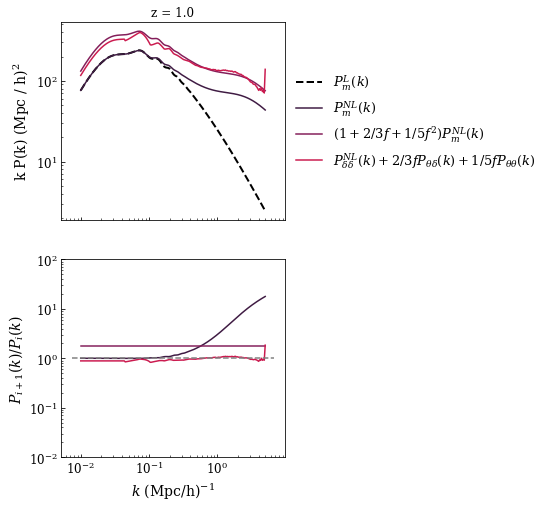

In [11]:
f = growth_factor(z)
pkkw = dict(
    label = r'$P_{\delta \delta}^{NL} (k) + 2/3 f P_{\theta \delta} (k) + 1/5 f P_{\theta \theta} (k)$'
)
pk_nlk = pk_nonlin[0, :] + 2/3 * f* td_demo + 1/5 * f**2 * tt_demo
pks.append([kh_nonlin, pk_nlk, pkkw])
plot_pk(pks)

$1/2 \int_{-1}^1 \frac{1}{1 + (k^2 \mu^2 \sigma_\alpha^2)/2} \frac{1}{1 + (k^2 \mu^2 \sigma_\beta^2)/2} d\mu$



<Figure size 432x288 with 0 Axes>

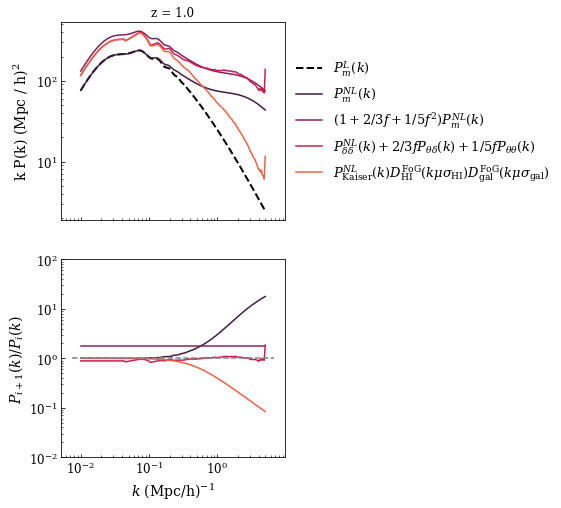

In [12]:
from scipy.integrate import quad
def integrand(mu, k, sigma_alpha, sigma_beta):
    numerator = 1.0
    denominator_alpha = 1.0 + (k**2 * mu**2 * sigma_alpha**2) / 2.0
    denominator_beta = 1.0 + (k**2 * mu**2 * sigma_beta**2) / 2.0
    return numerator / (denominator_alpha * denominator_beta)

def solve_integral(k, sigma_alpha, sigma_beta):
    # Define the limits of integration
    lower_limit = -1.0
    upper_limit = 1.0

    # Use quad from scipy to perform the numerical integration
    result, error = quad(integrand, lower_limit, upper_limit, args=(k, sigma_alpha, sigma_beta))
    
    return 0.5 * result  # Multiply the result by 0.5 as per the integral

fog = np.zeros_like(kh)

sigma_hi = 1.93
sigma_g = 3.4 # take some avg bt ELG and LRG
for i in range(len(kh)):
    fog[i] = solve_integral(kh[i], sigma_hi, sigma_g)

pkkw = dict(
    label = r'$P_{\mathrm{Kaiser}}^{NL} (k) D^{\mathrm{FoG}}_{\mathrm{HI}} (k \mu \sigma_{\mathrm{HI}}) D^{\mathrm{FoG}}_{\mathrm{gal}} (k \mu \sigma_{\mathrm{gal}})$'
)
pks.append([kh_nonlin, pk_nlk * fog, pkkw])
plot_pk(pks)

# Both At Same Time

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

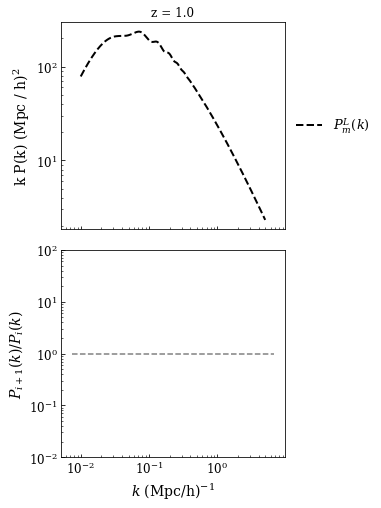

In [61]:
import copy
pks = []
pks_noeq = []
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, _, pk = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)

# format into dict
pkkw = dict(
    label = '$P_m^L (k)$',
    color = 'black',
    linestyle = 'dashed',
    linewidth = 2
)

pks.append([kh, pk[0,:], pkkw])
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'L'
pks_noeq.append([kh, pk[0, :], pkkw_noeq])

plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

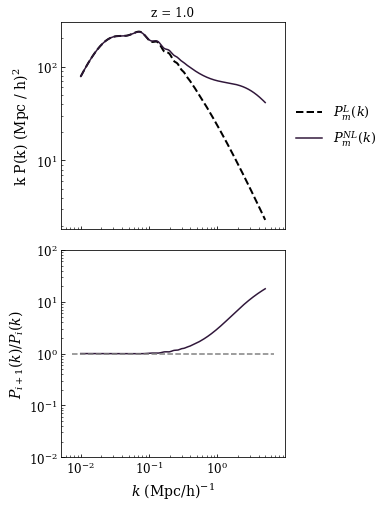

In [62]:
#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, _, pk_nonlin = results.get_matter_power_spectrum(minkh=mink, maxkh=maxk, npoints = npts)
pkkw = dict(
    label = '$P_m^{NL} (k)$'
)
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'NL'
pks_noeq.append([kh, pk_nonlin[0, :], pkkw_noeq])
pks.append([kh_nonlin, pk_nonlin[0, :], pkkw])
plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

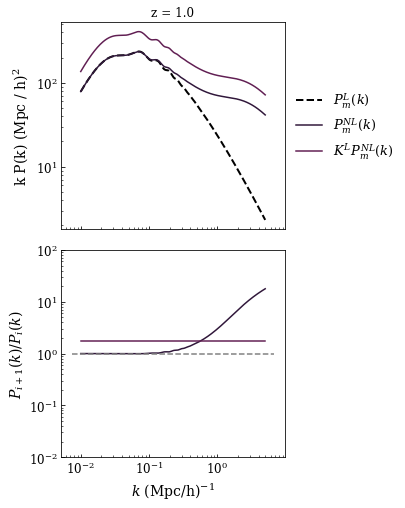

In [63]:
# linear Kaiser RSD
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def kaiser(z, bias):
    f = growth_factor(z)
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)
def growth_factor(z):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    return f
lnksr = kaiser(z, 1)
pkkw = dict(
    label = r'$K^L P_m^{NL} (k)$'
)
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'L Kaiser & NL'
pks_noeq.append([kh, pk_nonlin[0, :] * lnksr, pkkw_noeq])
pks.append([kh_nonlin, pk_nonlin[0, :] * lnksr, pkkw])

plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

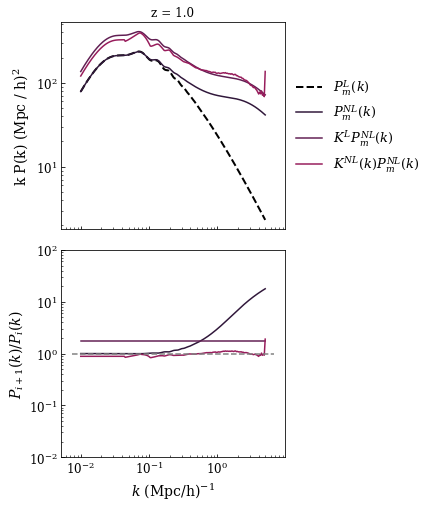

In [64]:
# non-linear Kaiser RSD, using 200 grid versions
td = pkl.load(open('theta_delta_demo_50.pkl', 'rb'))
tt = pkl.load(open('theta_theta_demo_50.pkl', 'rb'))
dd = pkl.load(open('delta_delta_demo_50.pkl', 'rb'))

td[1] /= 1e2
tt[1] /= 1e4

tt_interp = interp1d(tt[0], tt[1], kind = 'linear')
td_interp = interp1d(td[0], td[1], kind = 'linear')

tdfrac = td[1] / dd[1]
ttfrac = tt[1] / dd[1]

lintd = tdfrac[0]
lintt = ttfrac[0]

in_ks = kh[kh > td[0][0]]

in_tt = tt_interp(in_ks)
in_td = td_interp(in_ks)


tt_demo = pk_nonlin[0, :] * lintt
td_demo = pk_nonlin[0, :] * lintd

tt_demo[-len(in_ks):] = in_tt
td_demo[-len(in_ks):] = in_td

f = growth_factor(z)
pkkw = dict(
    label = r'$K^{NL} (k) P^{NL}_m (k)$'
)
pk_nlk = pk_nonlin[0, :] + 2/3 * f* td_demo + 1/5 * f**2 * tt_demo
pks.append([kh_nonlin, pk_nlk, pkkw])
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'NL Kaiser & NL'
pks_noeq.append([kh, pk_nlk, pkkw_noeq])
plot_pk(pks)

galaxy bias: 2.085672443425789
HI bias: 1.2512342415607032


(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

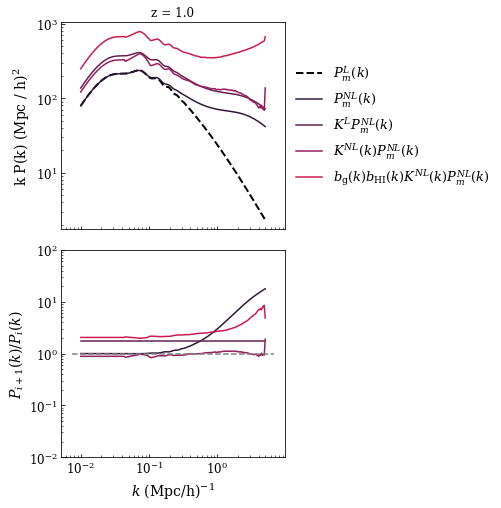

In [65]:
# including galaxy and HI bias
#loading gal bias
import pickle as pkl
from scipy.interpolate import interp1d
galb = pkl.load(open('gal_bias_demo_50.pkl', 'rb'))
hib = pkl.load(open('hi_bias_demo_50.pkl', 'rb'))

const_gbias = galb[1][0]
const_hbias = hib[1][0]
print('galaxy bias:',const_gbias)
print('HI bias:', const_hbias)

#tested with other kinds (quadratic), didn't have any difference
interp_f = interp1d(galb[0], galb[1], kind = 'linear', fill_value = const_gbias, bounds_error = False)
galb_intp = interp_f(kh)

interp_f = interp1d(hib[0], hib[1], kind = 'linear', fill_value = const_hbias, bounds_error = False)
hib_intp = interp_f(kh)
pkkw = dict(
    label = r'$b_{\rm{g}} (k) b_{\rm{HI}} (k) K^{NL} (k) P_m^{NL} (k)$'
)
nlpk_bias = pk_nonlin[0, :] * hib_intp * galb_intp + 2/3 * f* td_demo + 1/5 * f**2 * tt_demo
pks.append([kh, nlpk_bias, pkkw])
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'biases & NL Kaiser & NL'
pks_noeq.append([kh, nlpk_bias, pkkw_noeq])
plot_pk(pks)

(<Figure size 288x576 with 2 Axes>,
 array([<AxesSubplot:title={'center':'z = 1.0'}, ylabel='k P(k) (Mpc / h)$^2$'>,
        <AxesSubplot:xlabel='$k$ (Mpc/h)$^{-1}$', ylabel='$P_{i + 1} (k) / P_{i}(k)$'>],
       dtype=object))

<Figure size 432x288 with 0 Axes>

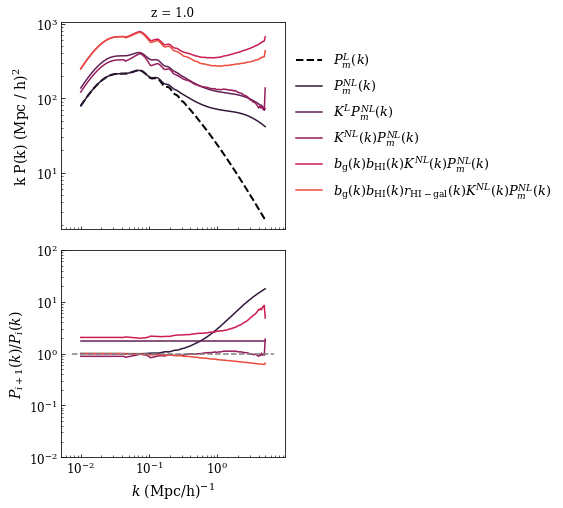

In [66]:
# including the correlation coefficient
cc = pkl.load(open('higal_cc_demo_50.pkl', 'rb'))
interp_f = interp1d(cc[0], cc[1], kind = 'linear', fill_value = 1, bounds_error = False)
cc_intp = interp_f(kh)
pkkw = dict(
    label = r'$b_{\rm{g}} (k) b_{\rm{HI}} (k) r_{\mathrm{HI-gal}} (k) K^{NL} (k) P_m^{NL} (k)$'
)
nlpk_bias_cc = pk_nonlin[0, :] * hib_intp * galb_intp * cc_intp + 2/3 * f* td_demo + 1/5 * f**2 * tt_demo

pks.append([kh, nlpk_bias_cc, pkkw])
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'corr. coef. & biases & NL Kaiser & NL'
pks_noeq.append([kh, nlpk_bias_cc, pkkw_noeq])
plot_pk(pks)

<Figure size 432x288 with 0 Axes>

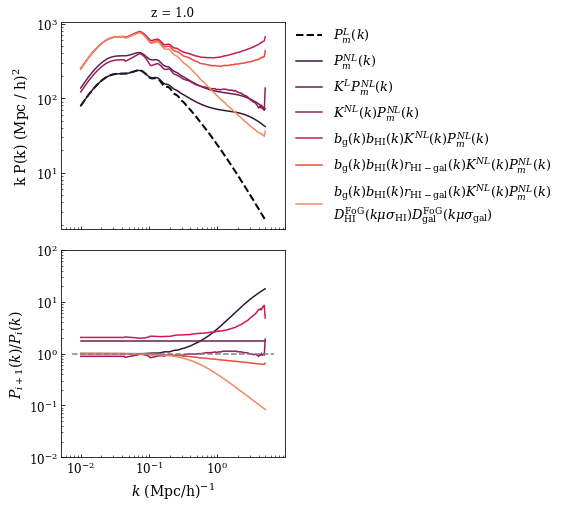

In [67]:
from scipy.integrate import quad
def integrand(mu, k, sigma_alpha, sigma_beta):
    numerator = 1.0
    denominator_alpha = 1.0 + (k**2 * mu**2 * sigma_alpha**2) / 2.0
    denominator_beta = 1.0 + (k**2 * mu**2 * sigma_beta**2) / 2.0
    return numerator / (denominator_alpha * denominator_beta)

def solve_integral(k, sigma_alpha, sigma_beta):
    # Define the limits of integration
    lower_limit = -1.0
    upper_limit = 1.0

    # Use quad from scipy to perform the numerical integration
    result, error = quad(integrand, lower_limit, upper_limit, args=(k, sigma_alpha, sigma_beta))
    
    return 0.5 * result  # Multiply the result by 0.5 as per the integral

fog = np.zeros_like(kh)

sigma_hi = 1.93
sigma_g = 3.4 # take some avg bt ELG and LRG
for i in range(len(kh)):
    fog[i] = solve_integral(kh[i], sigma_hi, sigma_g)

pkkw = dict(
    label = r'$b_{\rm{g}} (k) b_{\rm{HI}} (k) r_{\mathrm{HI-gal}} (k) K^{NL} (k) P_m^{NL} (k)$' + '\n' + \
    r'$D^{\mathrm{FoG}}_{\mathrm{HI}} (k \mu \sigma_{\mathrm{HI}}) D^{\mathrm{FoG}}_{\mathrm{gal}} (k \mu \sigma_{\mathrm{gal}})$'
)
pks.append([kh_nonlin, nlpk_bias_cc * fog, pkkw])
pkkw_noeq = copy.deepcopy(pkkw)
pkkw_noeq['label'] = 'FoG & corr. coef. & biases & NL Kaiser & NL'
pks_noeq.append([kh, nlpk_bias_cc * fog, pkkw_noeq])


<Figure size 432x288 with 0 Axes>

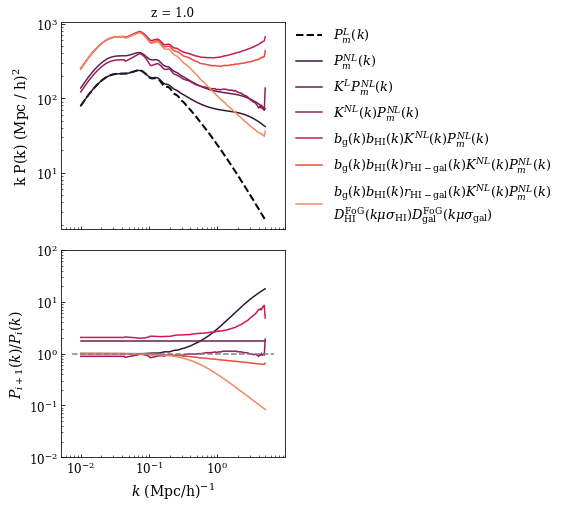

In [74]:
fig, axs = plot_pk(pks)
fig.savefig("pk_demo_eqtns_iterfrac.png", dpi = 150, bbox_inches = 'tight', facecolor = 'white')

<Figure size 432x288 with 0 Axes>

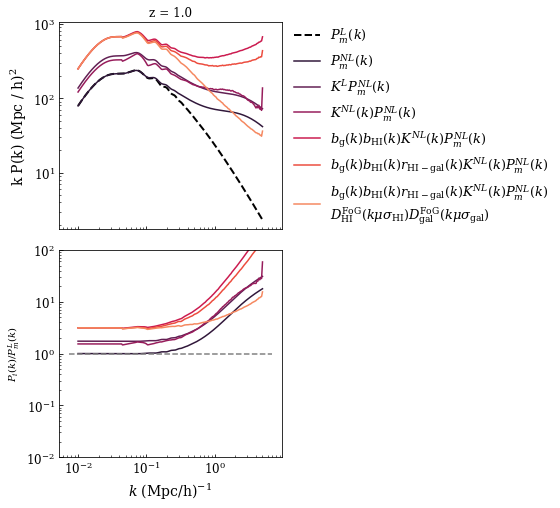

In [75]:
fig, axs = plot_pk(pks, frac_type = 'lin')
fig.savefig("pk_demo_eqtns_linfrac.png", dpi = 150, bbox_inches = 'tight', facecolor = 'white')

<Figure size 432x288 with 0 Axes>

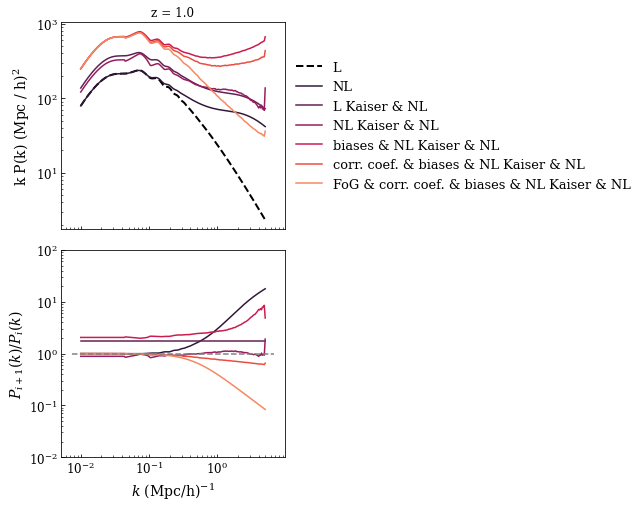

In [76]:
fig, axs = plot_pk(pks_noeq)
fig.savefig("pk_demo_verbal_iterfrac.png", dpi = 150, bbox_inches = 'tight', facecolor = 'white')